<a href="https://colab.research.google.com/github/harshas-repo/cyberbat/blob/main/cyberbat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset downlooading and extraction

In [ ]:
!curl -o dataset.zip https://zenodo.org/record/3678171/files/dev_data_fan.zip?download=1

In [ ]:
!unzip /content/dataset.zip

In [ ]:
!pip install torch==1.6.0 # uncomment this line to install pytorch, note the proposed model is strictly dependent on torch version 1.6.0.
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation # uncomment this line to install the nnAudio library.
!pip install transformers==3.0.0 # uncomment this line to install the transforms package.

### Audio Anamoly Detection Using MCFCC

Unsupervised Anomaly Detection by Airborne Sound of Industrial Machinery

A machine learning approach to machine anomaly detection on the MIMII dataset.

## How it Works?
Feature Extracted using MCFCC<br>
Trained using XGBoost

In [4]:
import numpy as np 
import pandas as pd 

import os
import hashlib
import matplotlib.pyplot as plt
import random
import sys
import scipy
import scipy.signal as signal
import seaborn as sns

# sound libraries
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile
import wave
import warnings
import pickle
warnings.filterwarnings('ignore')

In [5]:
def files_dictionary(path):    
    result={}
    #r ecursively go through the folders, making up the absolute path of the file
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            # collect the absolute path of the file from the parts
            full_filename=os.path.join(dirname, filename)
            # find the file and store the path.
            if 'anomaly' in full_filename:
                result[full_filename]=1
            else:
                result[full_filename]=0
    return result

files_with_marks=files_dictionary('/content/fan')

In [6]:
# checking the head of the data
for x in list(files_with_marks)[0:5]:
    print ("key {}, value {} ".format(x,  files_with_marks[x]))

key /content/fan/train/normal_id_00_00000180.wav, value 0 
key /content/fan/train/normal_id_02_00000718.wav, value 0 
key /content/fan/train/normal_id_06_00000522.wav, value 0 
key /content/fan/train/normal_id_04_00000491.wav, value 0 
key /content/fan/train/normal_id_04_00000456.wav, value 0 


In [7]:
# dictionary to data frame conversion
marks=pd.DataFrame(files_with_marks.items(), columns=['Filename', 'Anomaly'])
# head of the dataframe
marks.head(10)

,Filename,Anomaly
0,/content/fan/train/normal_id_00_00000180.wav,0
1,/content/fan/train/normal_id_02_00000718.wav,0
2,/content/fan/train/normal_id_06_00000522.wav,0
3,/content/fan/train/normal_id_04_00000491.wav,0
4,/content/fan/train/normal_id_04_00000456.wav,0
5,/content/fan/train/normal_id_02_00000288.wav,0
6,/content/fan/train/normal_id_02_00000861.wav,0
7,/content/fan/train/normal_id_02_00000411.wav,0
8,/content/fan/train/normal_id_04_00000180.wav,0
9,/content/fan/train/normal_id_06_00000738.wav,0


Load fan Sound Data

In [8]:
# enter the device time inside the double quotes to test
typeDevice = "fan"

## Getting a sample file

In [9]:
# dividing the normal and abnormal audio signals and storing in the repective string variables

normal_signal_file = ""
abnormal_signal_file = ""
for i in marks.Filename:
    if(i.split("/")[2] == typeDevice):
        if(i.split("/")[4].split("_")[0]=="normal" and normal_signal_file == ""):
            normal_signal_file = i
        elif(i.split("/")[4].split("_")[0] == "anomaly" and abnormal_signal_file == ""):
            abnormal_signal_file = i
    if(normal_signal_file != "" and abnormal_signal_file!= ""):
        break
print(normal_signal_file)

/content/fan/train/normal_id_00_00000180.wav


### Sample audio

1. **Sound:** Audio file

2. **Sample Rate:** (**sr**) Sample Rate of the audio file

In [10]:
def load_sound_file(wav_name, mono=True, channel=0):
   
    multi_channel_data, sampling_rate = librosa.load(wav_name, sr=None, mono=mono)
    signal = multi_channel_data
    #signal = np.array(multi_channel_data)[channel, :]
    
    return signal, sampling_rate

In [11]:
normalSignal, sr = load_sound_file(normal_signal_file)
abnormalSignal, sr = load_sound_file(abnormal_signal_file)
print(f'The signals have a {normalSignal.shape} shape. At {sr} Hz, these are {normalSignal.shape[0]/sr:.0f}s signals')

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals


Signal 16.000  (**16 kS/s**).

### Display waveform Normal Sound



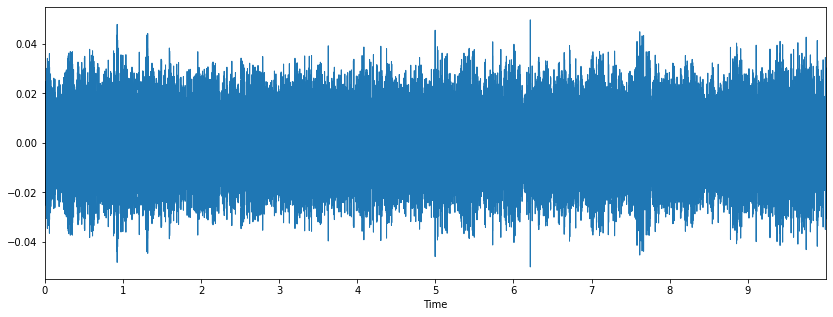

In [12]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(normalSignal, sr=sr)

### Display waveform Abnormal Sound

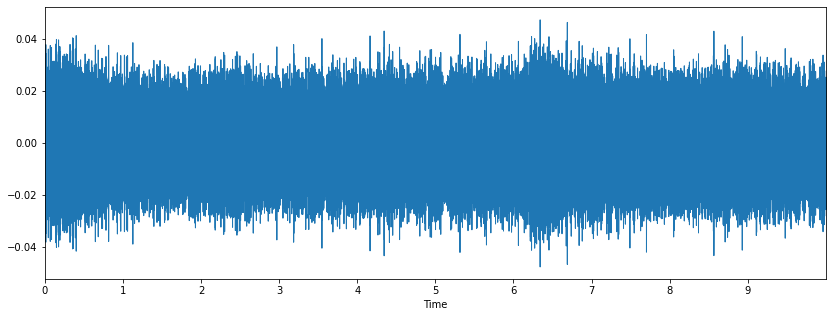

In [13]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(abnormalSignal, sr=sr)

### Sample sound test

In [14]:
ipd.Audio(normal_signal_file) #normal sound

In [15]:
ipd.Audio(abnormal_signal_file) #anormal sound

## Zero Crossing Rate
The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

In [16]:
n0 = 1
n1 = 10000
zero_crossings = librosa.zero_crossings(normalSignal[n0:n1], pad=False)
print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
1322


## Zero Crossing Rate for normal sound



[False False False ... False False False]
1322


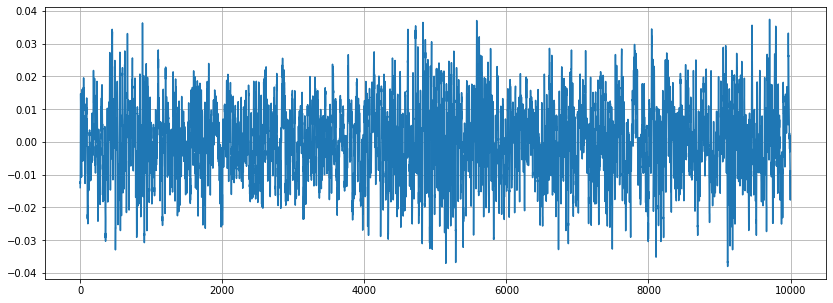

In [17]:
n0 = 1
n1 = 10000
zero_crossings = librosa.zero_crossings(normalSignal[n0:n1], pad=False)
print(zero_crossings)
print(sum(zero_crossings))
plt.figure(figsize=(14, 5))
plt.plot(normalSignal[n0:n1])
plt.grid()

## Zero Crossing Rate for abnormal sound


[False False False ... False  True False]
2772


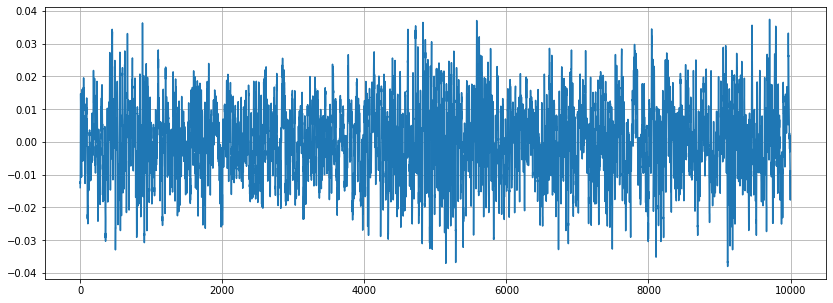

In [18]:
n0 = 1
n1 = 10000
zero_crossings = librosa.zero_crossings(abnormalSignal[n0:n1], pad=False)
print(zero_crossings)
print(sum(zero_crossings))
plt.figure(figsize=(14, 5))
plt.plot(normalSignal[n0:n1])
plt.grid()

## Spectral Centroid
It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(normalSignal, sr=sr)[0]
spectral_rolloff

array([5125.    , 5039.0625, 5039.0625, 5289.0625, 5367.1875, 5484.375 ,
       5367.1875, 5453.125 , 5265.625 , 5312.5   , 5187.5   , 5093.75  ,
       5179.6875, 5320.3125, 5320.3125, 5179.6875, 5109.375 , 5093.75  ,
       5007.8125, 5054.6875, 5179.6875, 5195.3125, 5195.3125, 5281.25  ,
       5265.625 , 5140.625 , 5476.5625, 5328.125 , 4757.8125, 4710.9375,
       5164.0625, 5140.625 , 5296.875 , 5367.1875, 5195.3125, 5187.5   ,
       5351.5625, 5539.0625, 5453.125 , 5492.1875, 5171.875 , 4812.5   ,
       5117.1875, 5195.3125, 5250.    , 5312.5   , 5335.9375, 5445.3125,
       5234.375 , 5078.125 , 5023.4375, 5250.    , 5171.875 , 5203.125 ,
       5265.625 , 5296.875 , 5242.1875, 5179.6875, 5203.125 , 5375.    ,
       5460.9375, 5148.4375, 5250.    , 5351.5625, 5312.5   , 5429.6875,
       5304.6875, 5304.6875, 5476.5625, 5437.5   , 5546.875 , 5367.1875,
       5476.5625, 5484.375 , 5382.8125, 5250.    , 5398.4375, 5328.125 ,
       5343.75  , 5281.25  , 5523.4375, 5437.5   , 

### Spectrogram Normal Sound

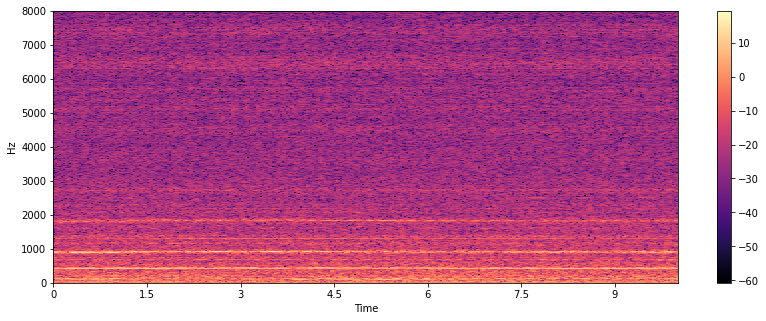

In [20]:
#display Spectrogram
X = librosa.stft(normalSignal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Spectrogram Abnormal Sound


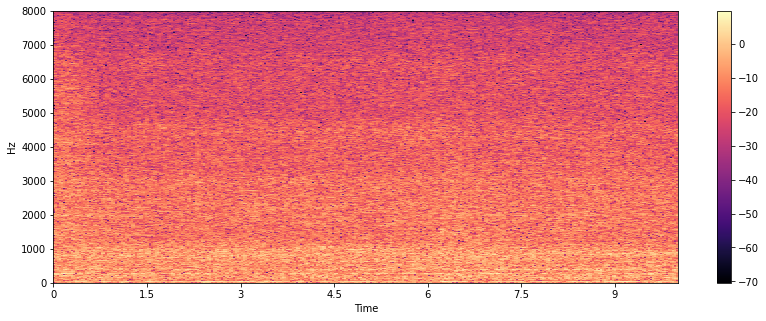

In [21]:
#display Spectrogram
X = librosa.stft(abnormalSignal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## MFCC — Mel-Frequency Cepstral Coefficients

This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

In [22]:
mfccs = librosa.feature.mfcc(normalSignal, sr=sr)
mfccs

array([[-283.7274   , -277.5553   , -278.86633  , ..., -278.22955  ,
        -280.6106   , -278.68008  ],
       [  80.14947  ,   82.74769  ,   79.50382  , ...,   82.64433  ,
          78.42217  ,   83.02254  ],
       [  19.021908 ,   15.0172   ,    8.562084 , ...,   14.10211  ,
          12.294034 ,   18.21196  ],
       ...,
       [ -11.45256  ,  -11.971312 ,  -14.745937 , ...,   -8.596469 ,
          -6.8722525,   -8.596002 ],
       [  -4.7974277,   -3.0219386,   -3.659053 , ...,    1.5541514,
           1.580245 ,   -0.6418153],
       [   6.7117596,    9.697164 ,    8.852806 , ...,    4.0901246,
           4.056479 ,    9.247582 ]], dtype=float32)

In [23]:
print(len(zero_crossings))
print(len(spectral_rolloff))
print(len(mfccs))

9999
313
20


In [24]:
#def audio_encode(audioFile):
#    signal, sampling_rate = load_sound_file(normal_signal_file)
#    return librosa.feature.mfcc(signal, sr=sampling_rate)

## Using nnAudio library as it supports GPU instead of using librosa.

refer the library here https://github.com/KinWaiCheuk/nnAudio

## Comparison with other libraries
| Feature | [nnAudio](https://github.com/KinWaiCheuk/nnAudio) | [torch.stft](https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/SpectralOps.cpp) | [kapre](https://github.com/keunwoochoi/kapre) | [torchaudio](https://github.com/pytorch/audio) | [tf.signal](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/python/ops/signal) | [torch-stft](https://github.com/pseeth/torch-stft) | [librosa](https://github.com/librosa/librosa) |
| ------- | ------- | ---------- | ----- | ---------- | ---------------------------- | ---------- | ------- |
| Trainable | ✅ | ❌| ✅ | ❌ | ❌ | ✅ | ❌ |
| Differentiable | ✅  | ✅ | ✅ | ✅ | ✅ | ✅ | ❌ |
| Linear frequency STFT| ✅  | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ |
| Logarithmic frequency STFT| ✅  | ❌ | ✅ | ❌ | ❌ | ❌ | ❌ |
| Inverse STFT| ✅  | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ |
| Griffin-Lim| ✅  | ❌ | ❌ | ✅ | ✅ | ❌ | ✅ |
| Mel | ✅ | ❌ | ✅ | ✅ | ✅ | ❌ | ✅ |
| MFCC | ✅  | ❌ | ❌ | ✅| ✅ | ❌ | ✅ |
| CQT | ✅ | ❌ | ❌ | ❌ | ❌ | ❌ | ✅ |
| Gammatone | ✅ | ❌ | ❌ | ❌ | ❌ | ❌ | ❌ |
| CFP<sup>1</sup> | ✅ | ❌ | ❌ | ❌ | ❌ | ❌ | ❌ |
| GPU support | ✅ | ✅ | ✅ | ✅ | ✅ | ✅ | ❌ |

✅: Fully support    ☑️: Developing (only available in dev version)    ❌: Not support

In [25]:
from nnAudio import Spectrogram
import torch
from scipy.stats import kurtosis
from scipy.stats import skew
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
import tensorflow as tf
import tensorflow.compat.v1 as tfc
sess = tfc.InteractiveSession()  # run an interactive session in Tf.

## Feature Extraction

In [27]:
def audio_encode(audioFile):
    signal, sampling_rate = load_sound_file(audioFile)
    #x = signal.mean(1) # Converting Multichannel  to Mono
    #signal = torch.tensor(signal, device='cuda:0').float() # casting the array into a PyTorch Tensor
    spec_layer = Spectrogram.MFCC(sr=sampling_rate,  n_mfcc=20, norm='ortho', verbose=False) # Initializing the model
    ft1 =  spec_layer(torch.from_numpy(signal))
    ft1 = ft1.numpy()
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    return pd.Series(np.hstack((ft1_trunc)))

In [28]:
spec_layer = audio_encode(marks.Filename[0])

In [29]:
spec_layer

0        -8.061544
1        -7.280763
2        -8.365574
3        -9.027159
4        -8.013272
           ...    
1873   -280.913025
1874   -274.641113
1875   -278.229553
1876   -280.610596
1877   -278.680084
Length: 1878, dtype: float32

In [30]:
fileTrain = []
fileTest = []
marks.Filename[0].split("/")
#using mfccs as it has less feature with lot of information on it and work in most audio files
for i in range(len(marks.Filename)):
    filename = marks.Filename[i].split("/")
    if(filename[2] == typeDevice):
        if(filename[3]=="train"):
            fileTrain.append([marks.Filename[i], marks.Anomaly[i]])
        else:
            fileTest.append([marks.Filename[i], marks.Anomaly[i]])     

In [31]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [32]:
# Prepare data

#train_data = pd.DataFrame()
#train_data['fname'] = fileTrain
#test_data = pd.DataFrame()
#test_data['fname'] = fileTest

#train_data = train_data['fname'].progress_apply(audio_encode)
#print('done loading train mfcc')
#test_data = test_data['fname'].progress_apply(audio_encode)
#print('done loading test mfcc')

#train_data['fname'] = train['fname']
#test_data['fname'] = audio_test_files

#train_data['label'] = train['label']
#test_data['label'] = np.zeros((len(audio_test_files)))

In [33]:
FeatureExtract = []
for i in range(len(fileTrain)):
    FeatureExtract.append([fileTrain[i][0], list(audio_encode(fileTrain[i][0])), fileTrain[i][1]])

In [34]:
# !pip install openpyxl # uncomment this is line for installing openpyxl library which helps to save the dataframe as excel file.

In [35]:
dataframe = pd.DataFrame(FeatureExtract, columns=["Filename", "FeatureSelection", "Anomaly"])
dataframe.to_excel("Featurelist.xlsx", sheet_name="Featurelist")

In [36]:
# printing the data frame converted to Excel
dataframe

,Filename,FeatureSelection,Anomaly
0,/content/fan/train/normal_id_00_00000180.wav,"[-8.061544418334961, -7.280762672424316, -8.36...",0
1,/content/fan/train/normal_id_02_00000718.wav,"[-8.233939170837402, -8.305038452148438, -9.53...",0
2,/content/fan/train/normal_id_06_00000522.wav,"[-6.810279846191406, -7.4938645362854, -6.9019...",0
3,/content/fan/train/normal_id_04_00000491.wav,"[-5.048834800720215, -6.142373561859131, -6.21...",0
4,/content/fan/train/normal_id_04_00000456.wav,"[-6.678231239318848, -7.147866725921631, -7.09...",0
...,...,...,...
3670,/content/fan/train/normal_id_00_00000834.wav,"[-5.021475791931152, -5.6216630935668945, -7.6...",0
3671,/content/fan/train/normal_id_06_00000040.wav,"[-10.530759811401367, -10.337560653686523, -7....",0
3672,/content/fan/train/normal_id_06_00000604.wav,"[-10.592055320739746, -8.388909339904785, -7.8...",0
3673,/content/fan/train/normal_id_02_00000829.wav,"[-9.165435791015625, -9.503171920776367, -8.78...",0


In [37]:
Y = dataframe["Anomaly"]
X = dataframe.drop(["Filename", "Anomaly"], axis=1)

In [38]:
X

,FeatureSelection
0,"[-8.061544418334961, -7.280762672424316, -8.36..."
1,"[-8.233939170837402, -8.305038452148438, -9.53..."
2,"[-6.810279846191406, -7.4938645362854, -6.9019..."
3,"[-5.048834800720215, -6.142373561859131, -6.21..."
4,"[-6.678231239318848, -7.147866725921631, -7.09..."
...,...
3670,"[-5.021475791931152, -5.6216630935668945, -7.6..."
3671,"[-10.530759811401367, -10.337560653686523, -7...."
3672,"[-10.592055320739746, -8.388909339904785, -7.8..."
3673,"[-9.165435791015625, -9.503171920776367, -8.78..."


In [39]:
temp = []
for i in X.FeatureSelection:
    temp.append(i)
temp = pd.DataFrame(temp)
X = temp

In [40]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877
0,-8.061544,-7.280763,-8.365574,-9.027159,-8.013272,-8.303071,-8.740243,-8.526339,-7.370051,-7.980264,-8.198061,-8.169743,-8.105657,-7.538025,-7.527235,-6.620435,-6.817657,-7.877957,-7.816831,-7.179663,-7.340744,-7.972771,-7.400592,-8.080618,-7.491732,-7.514905,-7.589692,-8.148219,-7.506625,-7.216813,-8.338594,-8.052182,-7.471800,-8.366868,-7.939577,-7.614361,-8.063817,-8.157672,-7.246736,-6.590652,...,-286.443451,-281.851562,-280.350800,-276.514221,-280.834656,-282.757660,-283.211212,-286.142731,-283.333008,-279.377441,-281.728210,-288.822693,-285.640747,-284.819366,-284.956268,-283.842743,-282.385010,-280.351318,-280.603455,-278.821198,-276.123077,-279.031067,-281.109894,-279.870148,-278.492645,-278.554596,-279.953827,-279.904327,-278.522095,-278.445526,-279.119568,-279.045776,-279.270782,-277.351624,-278.401886,-280.913025,-274.641113,-278.229553,-280.610596,-278.680084
1,-8.233939,-8.305038,-9.536047,-8.679190,-8.068871,-8.092343,-7.114204,-7.383014,-9.082551,-9.613676,-10.062388,-9.774658,-9.843731,-9.562661,-9.493174,-9.713609,-8.977047,-9.820280,-9.300440,-8.782522,-8.684259,-7.862549,-6.923593,-7.836244,-8.077057,-8.827001,-9.303851,-8.633081,-10.100245,-9.912485,-10.040451,-9.340916,-8.492263,-9.049947,-9.804186,-9.836119,-8.421652,-9.327905,-9.188189,-8.173166,...,-258.673950,-260.340424,-258.119537,-252.549728,-252.083145,-252.438934,-249.413406,-249.825699,-257.905518,-260.339630,-254.716736,-249.327545,-247.008499,-248.498749,-250.383301,-251.358429,-255.304703,-256.504761,-251.866699,-252.149750,-256.564087,-260.049408,-257.926300,-253.451996,-256.974548,-257.620087,-252.558243,-251.049500,-252.073776,-255.155365,-252.229950,-252.895447,-249.851730,-252.679031,-253.061172,-249.184402,-249.486435,-254.290390,-252.884003,-253.534470
2,-6.810280,-7.493865,-6.901995,-7.438060,-7.212748,-7.165187,-7.956460,-7.369004,-6.634703,-7.091306,-7.495503,-7.967902,-8.072368,-7.818324,-6.971539,-6.722711,-7.531942,-7.997706,-9.147829,-8.160772,-8.419845,-8.309520,-7.320686,-6.745649,-7.242444,-6.578701,-7.073601,-7.210940,-7.006545,-7.428289,-7.983701,-7.264909,-6.854594,-7.249579,-7.718665,-7.222251,-6.737410,-7.500980,-7.227763,-6.879134,...,-265.317139,-268.595520,-271.820709,-267.974854,-265.940277,-265.414520,-267.599487,-268.080841,-264.488281,-265.393127,-264.532043,-264.022919,-265.281189,-267.959625,-272.747498,-272.924744,-266.660156,-265.706696,-263.847351,-265.475067,-265.662628,-262.790619,-269.259583,-270.878754,-269.469666,-268.982605,-271.138733,-269.540619,-267.177826,-265.551483,-264.493073,-269.523071,-265.164062,-259.204803,-261.936523,-265.923584,-265.698914,-269.056641,-274.548462,-279.648071
3,-5.048835,-6.142374,-6.213971,-6.364255,-7.794335,-6.930543,-7.223118,-8.047864,-7.457903,-7.736082,-7.121878,-6.974756,-7.247487,-7.340839,-5.620492,-6.227107,-7.008124,-7.366056,-7.705235,-7.466011,-7.256090,-6.468358,-7.141897,-6.865839,-6.179042,-6.499803,-6.737749,-5.986417,-6.622488,-6.880553,-6.406847,-6.843816,-7.108158,-6.255980,-6.948579,-7.731318,-7.859276,-7.600915,-8.596922,-7.290591,...,-272.044434,-270.480743,-271.082581,-270.206207,-272.312256,-273.143616,-273.343353,-270.790588,-270.840424,-263.823273,-262.528351,-267.181885,-271.657104,-268.895599,-262.317322,-263.356140,-264.936035,-270.261871,-268.162750,-267.247772,-266.106537,-264.704590,-263.111450,-265.096222,-269.167267,-266.175598,-265.791351,-263.880310,-262.412567,-266.416504,-270.776917,-272.396515,-271.977997,-266.723511,-266.901398,-267.583038,-270.289001,-268.682770,-272.596527,-278.157196
4,-6.678231,-7.147867,-7.099056,-7.188389,-7.099402,-7.161096,-5.565014,-5.240277,-7.105770,-7.215997,-6.927394,-6.117932,-5.682458,-6.948

In [41]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
3670    0
3671    0
3672    0
3673    0
3674    0
Name: Anomaly, Length: 3675, dtype: int64

## Dimensionality Reduction- works better without dimensionaltiy reduction

In [42]:
# Avoided dimensional reduction to improve the accuracy of the model
# Apply scaling for PCA
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply PCA for dimension reduction
#pca = PCA(n_components=65).fit(X_scaled)
#X_pca = pca.transform(X_scaled)

#print(sum(pca.explained_variance_ratio_)) 

In [43]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, log_loss

## Train and Test Split

In [44]:
# Fit an SVM model
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

## Model training

In [45]:
def XGBoost(X, y):
    model = XGBClassifier(tree_method="gpu_hist", n_jobs=-1, use_label_encoder=False, verbosity = 0) 
    model.fit(X, y)
    return model

In [46]:
def Metrics(y_test, y_pred):
    Accuracy = accuracy_score(y_test, y_pred)*100
    Precision = precision_score(y_test, y_pred, average="macro")*100
    Recall = recall_score(y_test, y_pred, average="macro")*100
    f1Score = f1_score(y_test, y_pred, average="macro")*100
    return Accuracy, Precision, Recall, f1Score

## Training Score

In [47]:
model = XGBoost(X, Y)
y_pred = model.predict(x_test)
Accuracy, Precision, Recall, f1Score = Metrics(y_test, y_pred)

print("Accuracy", Accuracy)
print("Precision", Precision)
print("Recall", Recall)
print("F1Score", f1Score)

Accuracy 100.0
Precision 100.0
Recall 100.0
F1Score 100.0


In [48]:
FeatureExtractTest = []
for i in range(len(fileTest[:20])):
    FeatureExtractTest.append([fileTest[i][0], list(audio_encode(fileTest[i][0])), fileTest[i][1]])

In [49]:
dataframeTest = pd.DataFrame(FeatureExtract, columns=["Filename", "FeatureSelection", "Anomaly"])

In [50]:
Ytest = dataframeTest["Anomaly"]
Xtest = dataframeTest.drop(["Filename", "Anomaly"], axis=1)

In [51]:
temp = []
for i in Xtest.FeatureSelection:
    temp.append(i)
temp = pd.DataFrame(temp)
Xtest = temp

# Testing Score

In [52]:
y_pred = model.predict(Xtest)
Accuracy, Precision, Recall, f1Score = Metrics(Ytest, y_pred)

print("Accuracy", Accuracy)
print("Precision", Precision)
print("Recall", Recall)
print("F1Score", f1Score)

Accuracy 100.0
Precision 100.0
Recall 100.0
F1Score 100.0


Text(0.5, 1.0, 'Model Score')

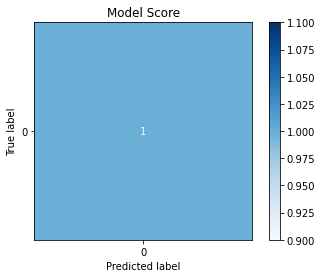

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, Xtest, Ytest, cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Model Score")

In [53]:
pickle.dump(model, open("exported_model_asp.sva", "wb"))

### References

https://kinwaicheuk.github.io/nnAudio/v0.2.0/_autosummary/nnAudio.Spectrogram.MFCC.html<br>
https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d